# eQTL Input 

I'm going to make the input files needed for the eQTL analysis. Some of the things we need are:

* Kinship matrix for EMMAX.
* `.phe`, `.cov` and `.ind` files for EMMAX. These are described in detail below.
* Gene expression estimates. I need to filter out genes that are not robustly expressed.
* Variants to test. I need to filter out variants that I don't want to test.

In [1]:
import copy
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peer
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import vcf as pyvcf

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

random.seed(20150605)

In [2]:
sns.set_context('notebook')

In [3]:
outdir = os.path.join(ciepy.root, 'output',
                      'eqtl_input')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'eqtl_input')
cpy.makedir(private_outdir)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
tpm = tpm[rna_meta.index]
log_tpm = np.log10(tpm + 1)

In [5]:
def transform_standard_normal(df):
    gc_ranks = df.rank(axis=1)
    gc_ranks = gc_ranks / (gc_ranks.shape[1] + 1)
    std_norm = stats.norm.ppf(gc_ranks)
    std_norm = pd.DataFrame(std_norm, index=gc_ranks.index, 
                            columns=gc_ranks.columns)
    return std_norm

## Cohort Information

I'm going to make some plots and get some info about the samples we are using
for eQTL analysis.

In [6]:
erna = rna_meta[rna_meta.in_eqtl]
esub = subject_meta.ix[erna.subject_id]
ewgs = wgs_meta.ix[erna.wgs_id]

In [7]:
print('We have {} distinct subjects for eQTL analysis.'.format(erna.shape[0]))

We have 215 distinct subjects for eQTL analysis.


In [8]:
erna.passage.value_counts()

12    141
13     39
15     11
14     11
16      7
20      2
30      1
26      1
24      1
22      1
Name: passage, dtype: int64

Most were collected at passage 12-16 although a few are at later passages.

In [9]:
esub.sex.value_counts()

F    119
M     96
Name: sex, dtype: int64

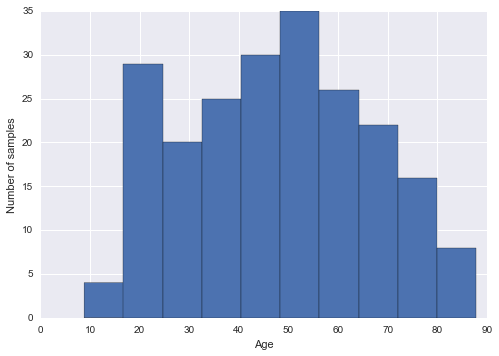

In [10]:
esub.age.hist()
plt.ylabel('Number of samples')
plt.xlabel('Age');

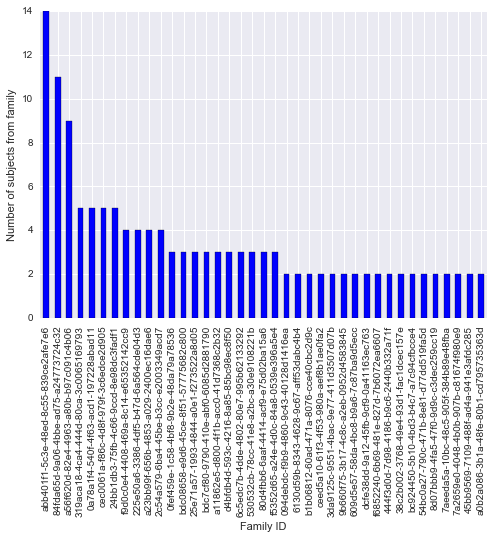

In [11]:
vc = esub.family_id.value_counts()
vc = vc[vc > 1]
vc.plot(kind='bar')
plt.ylabel('Number of subjects from family')
plt.xlabel('Family ID');

In [12]:
print('{} unique family IDs.'.format(len(set(esub.family_id))))
print('{} families have only one subject.'.format(sum(esub.family_id.value_counts() == 1)))

118 unique family IDs.
79 families have only one subject.


In [13]:
esub.ethnicity_group.value_counts()

European                         142
Asian                             30
Multiple ethnicities reported     19
Hispanic                          14
African American                   4
Indian                             4
Middle Eastern                     2
Name: ethnicity_group, dtype: int64

In [14]:
ewgs.cell.value_counts()

Blood         200
Fibroblast     15
Name: cell, dtype: int64

## Kinship Matrix

I'm going to create the kinship matrix using biallelic SNVs. I could use indels or other 
things but we should have more than enough information in biallelic SNVs. I want to come 
up with a set of independent (not in LD) SNPs that I can use to estimate relatedness. 
I'll use the 1,000 genomes data to LD prune our variant calls. I will first intersect
our calls with the 1,000 genome variant calls to find common SNPs. Then I'll LD prune
the 1KGP variants using unrelated Europeans. Then I'll 

I need to LD prune 
our variants first. I'll do this by identifying which of our variants are in 1000
genomes. Then I'll LD prune those variants based on 1KGP.

### Intersect cardips and 1KGP variants

In [15]:
dy = os.path.join(private_outdir, 'kinship')
cpy.makedir(dy)

In [16]:
# Intersect our variants with 1KGP variants so we get variants in both cardips and
# 1KGP to use for LD pruning. This takes several hours. This could probably be sped
# up by running separate intersections for each chromosome separately.

fn = os.path.join(dy, '1kgp_isec', '0000.vcf.gz')
autosomal_variants = os.path.join(ciepy.root, 'private_output', 'input_data',
                                  'autosomal_variants.vcf.gz')
if not os.path.exists(fn):
    vcfs = [('/publicdata/1KGP_20151103/ALL.chr{}.'
             'phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'.format(x))
            for x in range(1, 23)]
    c = ('bcftools isec -i\'TYPE="snp" & N_ALT == 1\' -c none -O z -p {} -n=2 {} {}'.format(
            os.path.join(dy, '1kgp_isec'), autosomal_variants, ' '.join(vcfs)))
    subprocess.check_call(c, shell=True)

### LD prune 1KGP variants

I'm going to use plink 1.9 for this since it can take VCF files
and it's faster. I'll do all chromosomes at once using an IPython cluster.
Make sure an IPython cluster is started with 22 engines (e.g. `ipcluster start -n 22`).
This step is actually quite fast and doesn't need to be done using a cluster.

In [17]:
tdy = os.path.join(dy, '1kgp_pruned')

if not os.path.exists(tdy):
    from ipyparallel import Client
    parallel_client = Client()
    dview = parallel_client[:]
    with dview.sync_imports():
        import os
        import subprocess

    cpy.makedir(tdy)
    dview.push(dict(tdy=tdy))
    %px os.chdir(tdy)

    # The plink --keep option needs a column for sample ID and a column for 
    # family ID. We can use the sample name as the family ID here.
    se = pd.read_table('/publicdata/1KGP_20151103/EUR_individuals.txt', header=None,
                       squeeze=True)
    se = se + '\t' + se
    with open(os.path.join(tdy, 'keep_samples.tsv'), 'w') as f:
        f.write('\n'.join(se.values) + '\n')

    vcfs = [os.path.join(dy, '1kgp_isec', '00{:02}.vcf.gz'.format(x)) for 
            x in range(1, 23)]
    commands = [('/frazer01/software/plink-1.90b3x/plink '
                 '--keep {} '
                 '--biallelic-only --indep-pairwise 50 5 0.2 --vcf {} '
                 '--out {}_pruned'.format(os.path.join(tdy, 'keep_samples.tsv'),
                                          x, os.path.split(x)[1].split('.')[0]))
                for x in vcfs]

    dview.scatter('commands', commands)
    %px [subprocess.check_call(c, shell=True) for c in commands];

In [18]:
# Now I need to take the plink text files and filter the 1KGP VCFs from the
# intersection step. I'll do this in parallel on the IPython cluster again.

tdy = os.path.join(dy, '1kgp_pruned')
vcfs = [os.path.join(dy, '1kgp_isec', '00{:02}.vcf.gz'.format(x)) for 
        x in range(1, 23)]
out_vcfs = [x.replace('.vcf.gz', '_pruned.vcf.gz').replace('1kgp_isec', '1kgp_pruned')
            for x in vcfs]
snps = [os.path.join(tdy, '00{:02}_pruned.prune.in'.format(i)) for i in range(1, 23)]

if not os.path.exists(out_vcfs[0]):
    from ipyparallel import Client
    parallel_client = Client()
    dview = parallel_client[:]
    with dview.sync_imports():
        import os
        import subprocess

    commands = ['/frazer01/software/bcftools-1.2/bcftools view -i\'ID=@{}\' '
                '{} -O z -o {}'.format(snps[i], vcfs[i], out_vcfs[i])
                for i in range(len(snps))]

    dview.scatter('commands', commands)
    %px [subprocess.check_call(c, shell=True) for c in commands];

    # We'll index the pruned VCF files as well.
    commands = ['/frazer01/software/bcftools-1.2/bcftools index -t {}'.format(x)
                for x in out_vcfs]
    dview.scatter('commands', commands)
    %px [subprocess.check_call(c, shell=True) for c in commands];

### Filter cardips variants

In [19]:
# Intersect our variants with 1KGP variants so we get variants in both cardips and
# 1KGP to use for LD pruning. This takes a few hours. This could probably be sped
# up by running separate intersections for each chromosome separately.

tdy = os.path.join(dy, 'cardips_pruned_isec')

if not os.path.exists(tdy):
    fn = os.path.join(dy, '1kgp_isec', '0000.vcf.gz')
    out_vcfs = [x.replace('.vcf.gz', '_pruned.vcf.gz').replace('1kgp_isec', '1kgp_pruned')
                for x in vcfs]
    c = ('bcftools isec -i\'TYPE="snp" & N_ALT == 1\' -c none -O z -p {} -n=2 {} {}'.format(
            tdy, fn, ' '.join(out_vcfs)))
    subprocess.check_call(c, shell=True)

### Make kinship matrix

Now we can use `epacts` to make the kinship matrix.

In [20]:
vcf = os.path.join(dy, 'cardips_pruned_isec', '0000.vcf.gz')

kmatrix = os.path.join(outdir, 'wgs.kin')
if not os.path.exists(kmatrix):
    c = ('epacts make-kin --vcf {} --min-maf 0.01 --min-callrate 0.95 '
         '--out {} --run 10'.format(vcf, kmatrix))
    subprocess.check_call(c, shell=True)
    
kdump = os.path.join(outdir, 'wgs.kindump')
if not os.path.exists(kdump):
    c = ('pEmmax kin-util --kinf {} --outf {} --dump'.format(
            kmatrix, os.path.splitext(kdump)[0]))
    subprocess.check_call(c, shell=True)
    
kmatrix = pd.read_table(kdump)

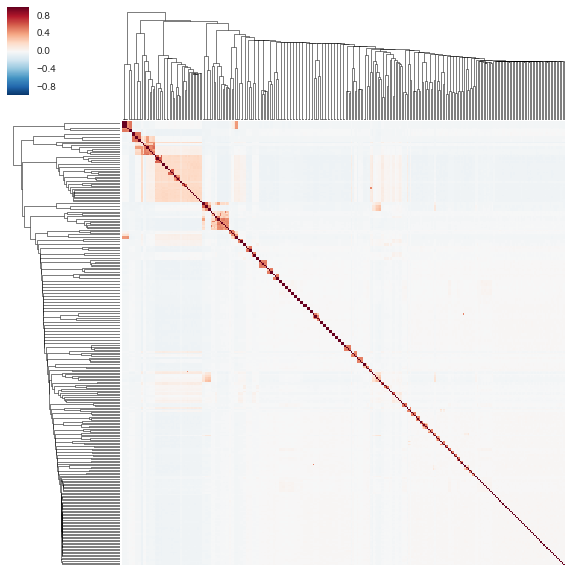

In [21]:
sns.clustermap(kmatrix, xticklabels=False, yticklabels=False, linewidths=0);

In [22]:
meta = wgs_meta.merge(subject_meta, left_on='subject_id', right_index=True)
kmatrix = kmatrix.ix[meta.index, meta.index]

vals = []
f = meta.father_id.dropna()
m = meta.mother_id.dropna()
for i in kmatrix.index:
    if i in f.index:
        fid = meta.ix[i, 'father_id']
        if fid in wgs_meta.subject_id.values:
            fid = wgs_meta[wgs_meta.subject_id == fid].index[0]
            vals.append(kmatrix.ix[i, fid])
    if i in m.index:
        mid = meta.ix[i, 'mother_id']
        if mid in wgs_meta.subject_id.values:
            mid = wgs_meta[wgs_meta.subject_id == mid].index[0]
            vals.append(kmatrix.ix[i, mid])

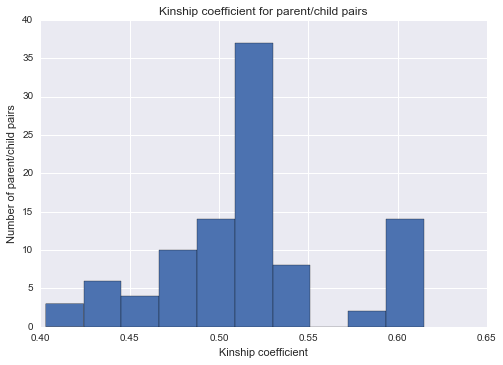

In [23]:
pd.Series(vals).plot(kind='hist')
plt.ylabel('Number of parent/child pairs')
plt.xlabel('Kinship coefficient')
plt.title('Kinship coefficient for parent/child pairs');

We can see that the kinship coefficient is near 0.5 for all parent/child pairs
as expected so the kinship matrix estimation seems to have worked well. The 
deviations from 0.5 can happen randomly but also are affected by mixed ancestry
for some samples.

## EMMAX Files

EMMAX needs the following files:
* `.phe` : Phenotype file. First column individual ID, second column phenotype value. I'll create
this on the fly for each gene.
* `.cov` : Covariate file. First column individual ID, subsequent columns are covariates. I tried
including an intercept but that didn't change the results so it doesn't seem to be necessary to 
include an intercept.
* `.ind` : VCF key. First column individual ID, second column is the one-based position of this key 
in the VCF header. I think this should be ordered such that the second column always increases, but 
you don't have to use every sample in the VCF. Currently, I use the ind file to subset the samples 
in the VCF file, so the order of the samples in the VCF doesn't matter.

In [26]:
fn = os.path.join(outdir, 'emmax_samples.tsv')
if not os.path.exists(fn):
    se = rna_meta[rna_meta.in_eqtl].wgs_id.copy(deep=True)
    se.sort_values(inplace=True)
    samples = pd.DataFrame(se)
    samples.column = ['wgs_id']
    samples['wgs_id'].to_csv(fn, sep='\t', header=False, index=False)
    
    fn = os.path.join(outdir, 'emmax_full.tsv')
    cov = pd.get_dummies(data=rna_meta.ix[samples.index], 
                         columns=['sequence_id'])
    cov = cov.merge(subject_meta, left_on='subject_id', right_index=True)
    cov.index = cov.wgs_id
    cov = cov[['sex', 'age', 'sequence_id_6', 'sequence_id_7', 'sequence_id_8']]
    cov['sex'] = cov.sex.apply(lambda x: {'M':1, 'F':2}[x])
    cov = cov.astype(int)
    cov.to_csv(fn, sep='\t', header=False)
    cov['sex'].to_csv(os.path.join(outdir, 'emmax_sex_only.tsv'), sep='\t', header=False)

In [27]:
fn = os.path.join(outdir, 'emmax_samples_unrelated.tsv')
if not os.path.exists(fn):
    se = rna_meta[rna_meta.in_unrelateds].wgs_id.copy(deep=True)
    se.sort_values(inplace=True)
    samples = pd.DataFrame(se)
    samples.column = ['wgs_id']
    samples['wgs_id'].to_csv(fn, sep='\t', header=False, index=False)
    
    fn = os.path.join(outdir, 'emmax_full_unrelated.tsv')
    cov = pd.get_dummies(data=rna_meta.ix[samples.index], 
                         columns=['sequence_id'])
    cov = cov.merge(subject_meta, left_on='subject_id', right_index=True)
    cov.index = cov.wgs_id
    cov = cov[['sex', 'age', 'sequence_id_6', 'sequence_id_7', 'sequence_id_8']]
    cov['sex'] = cov.sex.apply(lambda x: {'M':1, 'F':2}[x])
    cov = cov.astype(int)
    cov.to_csv(fn, sep='\t', header=False)
    cov['sex'].to_csv(os.path.join(outdir, 'emmax_sex_only_unrelated.tsv'), sep='\t', header=False)

## Gene Expression

I'm going to use RSEM TPM estimates.

In [18]:
fn = os.path.join(outdir, 'tpm_log_filtered_phe_std_norm.tsv')
if not os.path.exists(fn):
    tpm_f = log_tpm[rna_meta[rna_meta.in_eqtl].index]
    tpm_f = tpm_f[(tpm_f > np.log10(2)).sum(axis=1) >= 10]
    tpm_f = (tpm_f.T - tpm_f.mean(axis=1)).T
    tpm_f.to_csv(os.path.join(outdir, 'tpm_log_filtered.tsv'), sep='\t')
    # I'll also write a file with the WGS ID for each sample
    # for use with EMMAX.
    tpm_f.columns = rna_meta.ix[tpm_f.columns, 'wgs_id']
    tpm_f.to_csv(os.path.join(outdir, 'tpm_log_filtered_phe.tsv'), sep='\t')
    # Standard normal transformed.
    tpm_f_std_norm = transform_standard_normal(tpm_f)
    tpm_f_std_norm.to_csv(fn, sep='\t')

In [100]:
fns = [os.path.join(outdir, 'peer_20_factors.tsv'),
       os.path.join(outdir, 'peer_20_weights.tsv'),
       os.path.join(outdir, 'peer_20_precision.tsv'),
       os.path.join(outdir, 'peer_20_residuals.tsv')]
if sum([os.path.exists(x) for x in fns]) != len(fns):
    model = peer.PEER()
    model.setPhenoMean(tpm_f_std_norm)
    model.setNk(20)
    model.update()

    factors = pd.DataFrame(model.getX(), index=tpm_f_std_norm.index)
    factors.to_csv(os.path.join(outdir, 'peer_20_factors.tsv'), sep='\t',
                   header=False)
    weights = pd.DataFrame(model.getW(), index=tpm_f_std_norm.columns)
    weights.to_csv(os.path.join(outdir, 'peer_20_weights.tsv'), sep='\t',
                   header=False)
    precision = pd.Series(model.getAlpha()[:, 0])
    precision.to_csv(os.path.join(outdir, 'peer_20_precision.tsv'), 
                     sep='\t', index=False, header=False)
    residuals = pd.DataFrame(model.getResiduals(), index=tpm_f_std_norm.index,
                             columns=tpm_f_std_norm.columns)
    residuals.to_csv(os.path.join(outdir, 'peer_20_residuals.tsv'),
                     sep='\t')
else:
    factors = pd.read_table(os.path.join(outdir, 'peer_20_factors.tsv'),
                            index_col=0, header=None)
    weights = pd.read_table(os.path.join(outdir, 'peer_20_weights.tsv'),
                            index_col=0, header=None)
    precision = pd.read_table(os.path.join(outdir, 'peer_20_precision.tsv'),
                              header=None, squeeze=True)
    residuals = pd.read_table(os.path.join(outdir, 'peer_20_residuals.tsv'),
                              index_col=0)

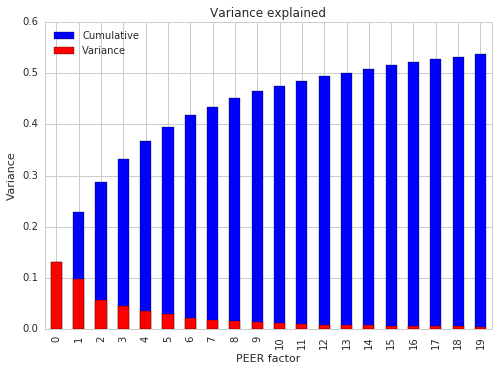

In [104]:
with sns.axes_style('whitegrid'):
    pd.Series(1 / precision).cumsum().plot(label='Cumulative', kind='bar')
    (1 / precision).plot(kind='bar', label='Variance', color='red')
    plt.title('Variance explained')
    plt.ylabel('Variance')
    plt.xlabel('PEER factor')
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(outdir, 'peer_variance.pdf'))

In [165]:
# Find correlation between PEER factors and known covariates.
vals = []
pvals = []
for c in cov.columns:
    tvals = []
    tpvals = []
    for w in range(weights.shape[1]):
        res = stats.spearmanr(cov[c], weights.ix[:, w])
        tvals.append(res[0])
        tpvals.append(res[1])
    vals.append(tvals)
    pvals.append(tpvals)
c_corrs = pd.DataFrame(vals, index=cov.columns).T
c_pvals = pd.DataFrame(pvals, index=cov.columns).T

In [168]:
# Find correlation between PEER factors and family membership.
vc = subject_meta.ix[wgs_meta.ix[cov.index, 'subject_id'], 'family_id'].value_counts()
vc = vc[vc >= 4]
vals = []
pvals = []
for f in vc.index:
    tvals = []
    tpvals = []
    for w in range(weights.shape[1]):
        t = subject_meta.ix[wgs_meta.ix[tpm_f_std_norm.columns, 'subject_id'], 'family_id'] == f
        res = stats.spearmanr(t, weights.ix[:, w])
        tvals.append(res[0])
        tpvals.append(res[1])
    vals.append(tvals)
    pvals.append(tpvals)
f_corrs = pd.DataFrame(vals, index=vc.index).T
f_pvals = pd.DataFrame(pvals, index=vc.index).T

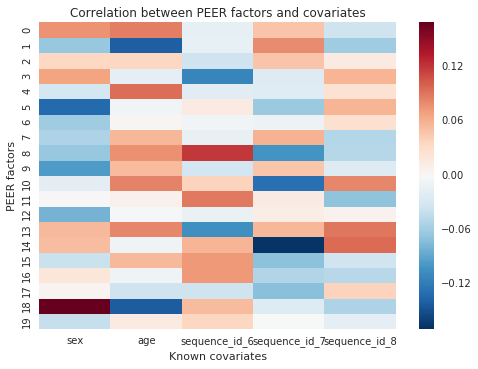

In [169]:
t = sns.heatmap(c_corrs)
plt.xlabel('Known covariates')
plt.ylabel('PEER factors')
plt.title('Correlation between PEER factors and covariates')
plt.savefig(os.path.join(outdir, 'peer_cov_corr.pdf'))

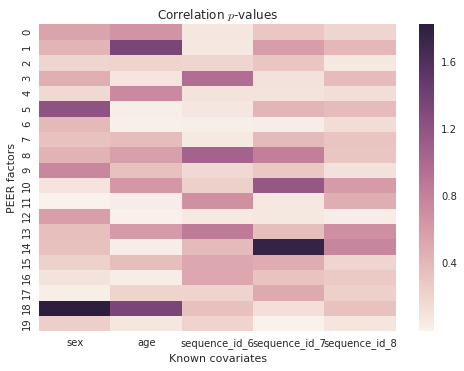

In [171]:
sns.heatmap(-np.log10(c_pvals))
plt.xlabel('Known covariates')
plt.ylabel('PEER factors')
plt.title('Correlation $p$-values');

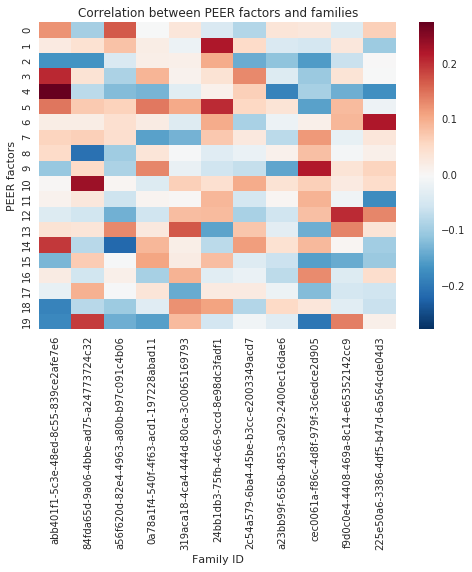

In [172]:
sns.heatmap(f_corrs)
plt.xlabel('Family ID')
plt.ylabel('PEER factors')
plt.title('Correlation between PEER factors and families')
plt.savefig(os.path.join(outdir, 'peer_fam_corr.pdf'))

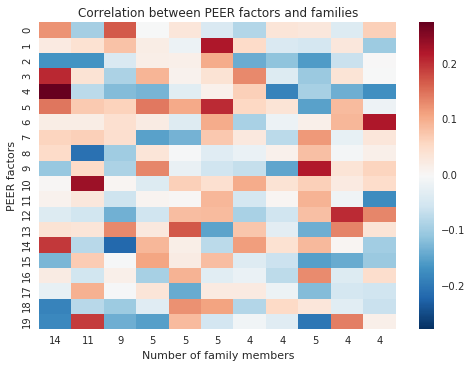

In [173]:
t = copy.deepcopy(f_corrs)
t.columns = subject_meta.family_id.value_counts()[t.columns]
sns.heatmap(t)
plt.xlabel('Number of family members')
plt.ylabel('PEER factors')
plt.title('Correlation between PEER factors and families')
plt.savefig(os.path.join(outdir, 'peer_fam_corr_num.pdf'))

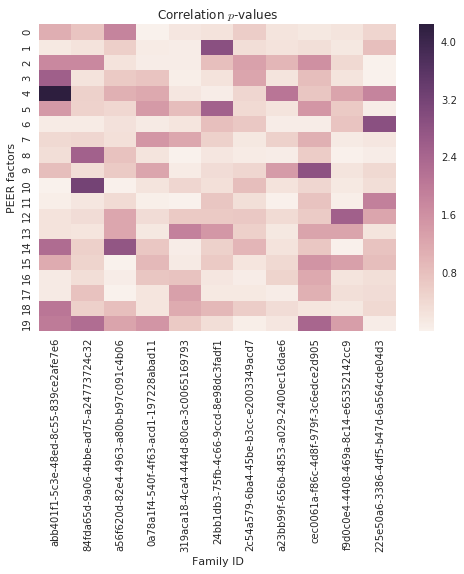

In [174]:
sns.heatmap(-np.log10(f_pvals))
plt.xlabel('Family ID')
plt.ylabel('PEER factors')
plt.title('Correlation $p$-values');

It seems that some of the PEER factors capture known covariates
or signals from families. For instance, factor 5 (labeled 4 above
because counting starts at zero) seems to be correlated with membership
in the largest family abb401f1. The 15th peer factor seems to be 
associated with batch. Some are simply associated with known covariates
however. I think I will include the first 15 PEER factors to capture 
the 15th one that is associated with batch. I can supply covariates
to EMMAX as well although if necessary.

In [182]:
fns = [os.path.join(outdir, 'peer_15_factors.tsv'),
       os.path.join(outdir, 'peer_15_weights.tsv'),
       os.path.join(outdir, 'peer_15_precision.tsv'),
       os.path.join(outdir, 'peer_15_residuals.tsv'),
       os.path.join(outdir, 'tpm_log_filtered_phe_std_norm_peer_resid.tsv')]
if sum([os.path.exists(x) for x in fns]) != len(fns):
    model_15 = peer.PEER()
    model_15.setPhenoMean(tpm_f_std_norm)
    model_15.setNk(10)
    model_15.update()

    factors_15 = pd.DataFrame(model_15.getX(), index=tpm_f_std_norm.index)
    factors_15.to_csv(os.path.join(outdir, 'peer_15_factors.tsv'), 
                      sep='\t',header=False)
    weights_15 = pd.DataFrame(model_15.getW(), index=tpm_f_std_norm.columns)
    weights_15.to_csv(os.path.join(outdir, 'peer_15_weights.tsv'), 
                      sep='\t', header=False)
    precision_15 = pd.Series(model_15.getAlpha()[:, 0])
    precision_15.to_csv(os.path.join(outdir, 'peer_10_precision.tsv'), 
                        sep='\t', index=False, header=False)
    residuals_15 = pd.DataFrame(model_15.getResiduals(), index=tpm_f_std_norm.index,
                                columns=tpm_f_std_norm.columns)
    residuals_15.to_csv(os.path.join(outdir, 'peer_15_residuals.tsv'),
                        sep='\t')
    
    residuals_std_norm = transform_standard_normal(residuals_15)
    residuals_std_norm.to_csv(
        os.path.join(outdir, 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), sep='\t')
else:
    factors_15 = pd.read_table(os.path.join(outdir, 'peer_15_factors.tsv'),
                               index_col=0, header=None)
    weights_15 = pd.read_table(os.path.join(outdir, 'peer_15_weights.tsv'),
                               index_col=0, header=None)
    precision_15 = pd.read_table(os.path.join(outdir, 'peer_15_precision.tsv'),
                                 header=None, squeeze=True)
    residuals_15 = pd.read_table(os.path.join(outdir, 'peer_15_residuals.tsv'),
                                 index_col=0)

## Variant Regions

I'm going to identify the regions within 1 megabase of the TSSs for each gene whose
variants I want to test.

In [183]:
fn = os.path.join(outdir, 'variant_regions.bed')
if not os.path.exists(fn):
    variant_regions = cpb.gencode.make_promoter_bed(cpy.gencode_gtf, merge_by_gene=True,
                                                    up=1000000, down=1000000, out=fn)
else:
    variant_regions = pbt.BedTool(fn)

In [184]:
a = len(variant_regions)
b = gene_info.shape[0]
print('There are {} genes and {} regions'.format(b, a))

There are 57820 genes and 57820 regions


In principle, there could be multiple regions per gene if a gene has TSSs located more than
1MB apart. In practice, this doesn't happen.

In [185]:
fn = os.path.join(outdir, 'gene_to_regions.p')
if not os.path.exists(fn):
    gene_to_regions = dict()
    for r in variant_regions:
        gene = r.name.split('_')[0]
        gene_to_regions[gene] = gene_to_regions.get(gene, []) + ['{}:{}-{}'.format(
                r.chrom, r.start, r.end)]
    fn = os.path.join(outdir, 'gene_to_regions.p')
    cPickle.dump(gene_to_regions, open(fn, 'wb') )

## SNV Filtering

I want to filter sites that are out of HWE. I'll choose the Europeans who either aren't in families
or one European from each family. 

In [28]:
subject_meta.ethnicity_group.value_counts()

European                         191
Asian                             30
Multiple ethnicities reported     20
Hispanic                          18
African American                   7
Indian                             5
Middle Eastern                     3
Name: ethnicity_group, dtype: int64

In [29]:
tdf = subject_meta[subject_meta.ethnicity_group == 'European']
a = tdf[tdf.family_id.isnull()]
b = tdf.dropna(subset=['family_id'])
b = b.drop_duplicates(subset=['family_id'])
tdf = pd.concat([a, b])
print('Number to use for HWE: {}'.format(tdf.shape[0]))

Number to use for HWE: 104


In [ ]:
fn = os.path.join(private_outdir, 'filtered_european.vcf.gz')
if not os.path.exists(fn):
    v = os.path.join(ciepy.root, 'private_output', 'input_data',
                     'autosomal_variants.vcf.gz')
    samples = wgs_meta[wgs_meta.subject_id.apply(lambda x: x in tdf.index)].index
    c = ('bcftools view -m2 -M2 --min-ac 1:minor {} -Ov '
         '| vcftools --vcf - --indv {} --hwe 0.000001 --max-missing 0.05 --recode --stdout '
         '| bgzip > {}'.format(
            v, ' --indv '.join(samples), fn))
    subprocess.check_call(c, shell=True)
    shutil.move('out.log', os.path.join(private_outdir, 'hwe_filtering.log'))
    c = ('bcftools index {}'.format(fn))
    subprocess.check_call(c, shell=True)
    c = ('bcftools index -t {}'.format(fn))
    subprocess.check_call(c, shell=True)

In [ ]:
fn = os.path.join(private_outdir, 'filtered_all', '0000.vcf.gz')
if not os.path.exists(fn):
    filtered_vcf = os.path.join(private_outdir, 'filtered_european.vcf.gz')
    all_vcf = os.path.join(ciepy.root, 'private_output', 'input_data',
                           'autosomal_variants.vcf.gz')
    out = os.path.join(private_outdir, 'filtered_all')
    c = ('bcftools isec -O z -p {} -n=2 -w1 {} {}'.format(
            out, all_vcf, filtered_vcf))
    subprocess.check_call(c, shell=True)
    c = ('bcftools index {}'.format(fn))
    subprocess.check_call(c, shell=True)
    c = ('bcftools index -t {}'.format(fn))
    subprocess.check_call(c, shell=True)